# 0217 - Model training 2

- Sidethon_Model_training_seul_v1 노트북에서 만든 tf.data를 사용해서 모델 훈련 진행

In [1]:
# 사용하지 않는 메모리 비우기
import gc

gc.collect()

50

- 사용하지 않는 노트북은 커널을 종료했고, 메모리 캐시를 비우는 코드르 실행했지만 여전히 2928MiB 용량을 차지하고 있다

<img width="609" alt="Screenshot 2024-02-18 at 00 13 09" src="https://github.com/Kimgabe/PJ_Quick_draws/assets/140625136/899cc0d4-50ce-417d-bc17-bce6a9065489">


- 아까 GPU 활성화하는 코드를 사용할때 만들어진것 같은데, [블로그](https://d-life93.tistory.com/429)내용을 참고해보면 문제가 없어보이기도 하고..
    - 이 부분은 미팅때 질문해보고, 커널을 새로 만들어서 아래 내용 학습 진행

# == Make pipeline ==

In [1]:
# import basic library
import pandas as pd      # pandas 라이브러리를 pd로 가져오기
import numpy as np       # numpy 라이브러리를 np로 가져오기
import os                # os 라이브러리 가져오기
import json              # json 라이브러리 가져오기
import cv2               # OpenCV 라이브러리 가져오기
import tensorflow as tf  # TensorFlow 라이브러리 가져오기
from tensorflow.keras.utils import to_categorical  # TensorFlow의 to_categorical 함수 가져오기
import matplotlib.pyplot as plt

In [2]:
# load label_names pkl file : data lable이 리스트로 담겨있는 파일

import pickle

with open('../data/label_names.pkl', 'rb') as f:
    label_names = pickle.load(f)

In [3]:
label_names[:5]

['key', 'bus', 'apple', 'fire hydrant', 'marker']

In [4]:
# 파일 경로 설정
data_folder_path = '../data'
train_file_path = os.path.join(data_folder_path, 'train_simplified')
base_path = train_file_path + '/shuffle_raw_gzs'
num_files = 1  # 사용할 파일 개수 지정
df_files = [os.path.join(base_path, f'train_k{k}.gz') for k in range(num_files)]

# 파일 리스트 확인
print("경량화 시킨 gz 파일의 수:", len(df_files))

경량화 시킨 gz 파일의 수: 1


In [5]:
# draw_strokes function : 좌표값을 이미지로 만드는 함수
def draw_strokes(raw_strokes, image_size=128, line_width=6):
    border_offset = line_width * 2  # 테두리 공백 크기
    stroke_list = []  # raw_strokes를 NumPy 배열로 변환한 리스트
    bounds_info = {"min_x": float('inf'), "min_y": float('inf'),  # 최소 x, y 좌표 초기화
                   "max_x": float('-inf'), "max_y": float('-inf')}  # 최대 x, y 좌표 초기화
    
    # raw_strokes의 각 stroke에 대해 NumPy 배열로 변환하고 경계 좌표 갱신
    for stroke in raw_strokes:
        np_stroke = np.array(stroke)  # stroke를 NumPy 배열로 변환
        stroke_list.append(np_stroke)    # 변환된 배열을 stroke_list에 추가
        # 최소/최대 x, y 좌표 갱신
        bounds_info["min_x"] = min(bounds_info["min_x"], min(np_stroke[0]))
        bounds_info["max_x"] = max(bounds_info["max_x"], max(np_stroke[0]))
        bounds_info["min_y"] = min(bounds_info["min_y"], min(np_stroke[1]))
        bounds_info["max_y"] = max(bounds_info["max_y"], max(np_stroke[1]))
    
    # 빈 이미지 생성
    new_image = np.zeros((image_size, image_size, 3), dtype=float)
    original_width = bounds_info["max_x"] - bounds_info["min_x"]  # 원본 그림의 너비
    original_height = bounds_info["max_y"] - bounds_info["min_y"]  # 원본 그림의 높이
    ratio = max(original_width, original_height) / (image_size - border_offset * 2)  # 비율 계산
    
    # 비율이 0일 경우 빈 이미지 반환
    if ratio == 0:
        return new_image

    # 각 stroke의 좌표를 새로운 크기에 맞게 조정하여 이미지에 그리기
    for np_stroke in stroke_list:
        np_stroke[0] = (np_stroke[0] - bounds_info["min_x"]) / ratio + border_offset  # x 좌표 조정
        np_stroke[1] = (np_stroke[1] - bounds_info["min_y"]) / ratio + border_offset  # y 좌표 조정
        # 선 그리기
        for i in range(len(np_stroke[0]) - 1):
            start_x, start_y = int(np_stroke[0][i]), int(np_stroke[1][i])  # 시작점 좌표
            end_x, end_y = int(np_stroke[0][i + 1]), int(np_stroke[1][i + 1])  # 끝점 좌표
            new_image = cv2.line(new_image, (start_x, start_y), (end_x, end_y), (255, 255, 255), line_width)  # 선 그리기
    
    return new_image  # 완성된 이미지 반환

In [6]:
# ImgDataGenerator Class

import pandas as pd
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import cv2               # OpenCV 라이브러리 가져오기

# 파일을 하나씩 넘겨주는 generator
class ImgDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df_files, input_shape, batchsize, label_names, num_files, lw=3, state='Train', smoothing_factor=0.1):
        # 클래스 초기화 함수
        self.df_files = sorted(df_files)[:num_files]  # 데이터프레임 파일 리스트, 파일명 기준 오름차순 정렬 후 지정된 개수만큼 선택
        self.file_sel = 0  # 현재 사용할 파일 인덱스
        self.batchsize = batchsize  # 배치 크기
        self.input_shape = input_shape  # 입력 이미지 모양
        self.label_names = label_names  # 레이블 이름
        self.lw = lw  # 선의 너비
        self.state = state  # 상태 (Train, Test)
        self.smoothing_factor = smoothing_factor  # 스무딩 팩터
        self.on_epoch_end()  # epoch 종료시 호출

    def smooth_labels(self, labels):
        # 레이블을 부드럽게 만드는 함수
        labels *= (1 - self.smoothing_factor)
        labels += (self.smoothing_factor / len(self.label_names))
        return labels

    def __len__(self):
        # 데이터셋의 길이 반환
        return -(-len(self.df) // self.batchsize)
    
    def __getitem__(self, index):
        # 주어진 인덱스에 해당하는 데이터 가져오기
        try:
            batch_idx = self.idx[index * self.batchsize:(index + 1) * self.batchsize]
            h, w, ch = self.input_shape
            X = np.zeros((len(batch_idx), h, w, ch))
            y = np.zeros((len(batch_idx), len(self.label_names)))

            for i, idx in enumerate(batch_idx):
                row = self.df.iloc[idx]
                raw_strokes = json.loads(row['drawing'])
                # draw_strokes 함수 호출하여 이미지 데이터 생성
                X[i, :, :, ] = draw_strokes(raw_strokes, image_size=h, line_width=self.lw)

                if self.state != 'Test':
                    label_index = row['y']
                    label = to_categorical(label_index, num_classes=len(self.label_names))
                    y[i, :] = self.smooth_labels(label)

            return (X, y) if self.state != 'Test' else X
        
        except Exception as e:
            print(f"오류가 발생한 파일: {self.df_files[self.file_sel]}")
            print(f"오류 상세 정보: {e}")
            raise e

    def on_epoch_end(self):
        # epoch 종료시 호출되는 함수
        try:
            self.df = pd.read_csv(self.df_files[self.file_sel], compression='gzip')  # .gz 파일 읽기 추가
            self.idx = np.tile(np.arange(len(self.df)), 2)
            if self.state == 'Train':
                np.random.shuffle(self.idx)
            self.file_sel = (self.file_sel + 1) % len(self.df_files)
            
        except Exception as e:
            print

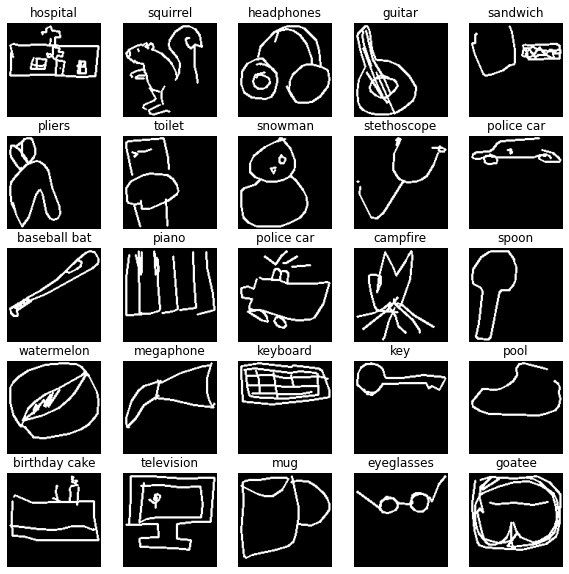

In [7]:
# ImgDataGenerator 인스턴스 생성을 위한 설정
input_shape = (128, 128, 3)  # 입력 이미지의 형태 (높이, 너비, 채널)
batch_size = 25  # 배치 사이즈

# ImgDataGenerator 클래스의 인스턴스 생성
## state: DataCheck로 설정해서 Train 준비에서 제외
gen_data_check = ImgDataGenerator(df_files=df_files, input_shape=input_shape, batchsize=batch_size, label_names=label_names, num_files=num_files, state='DataCheck', lw=2)

# 첫 번째 배치 데이터 가져오기 및 시각화
xx, y = gen_data_check[0]
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
labels = np.argmax(y, axis=1)  # 레이블 인덱스

# 이미지를 0에서 1 사이의 값으로 변환
xx = xx.astype(float) / 255.0

# 5x5 그리드에서 각 셀에 대해 이미지를 시각화하는 반복문
for i in range(25):
    axs[i // 5, i % 5].imshow(xx[i])  # 이미지 플로팅
    axs[i // 5, i % 5].axis('off')  # 축 숨기기
    axs[i // 5, i % 5].set_title(gen_data_check.label_names[labels[i]])  # 레이블 이름 설정

plt.show()

In [8]:
import tensorflow as tf

# GPU 장치를 사용할 수 있는지 확인합니다.
print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))

# GPU를 사용할 수 있다면, GPU 메모리 증가 옵션을 설정합니다.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # 모든 GPU 메모리를 동적으로 할당합니다.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "개의 논리적 GPU 사용 가능:", len(logical_gpus))
    except RuntimeError as e:
        # 프로그램 시작시에만 실행됩니다.
        print(e)

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 개의 논리적 GPU 사용 가능: 1


- 여기에서 메모리 254M가 할당됨
<img width="604" alt="Screenshot 2024-02-18 at 10 41 13" src="https://github.com/Kimgabe/PJ_Quick_draws/assets/140625136/74de0524-12c8-4eab-8e89-bea9762b1bea">


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 1. 데이터 파일 준비
base_path = train_file_path + '/shuffle_raw_gzs'  # 실제 train_file_path 변수에 맞는 경로를 설정해야 함

# 학습에 사용할 데이터 개수 입력
num_files = int(input("학습에 사용할 데이터 개수를 입력하세요: "))


df_files = [os.path.join(base_path, f'train_k{k}.gz') for k in range(num_files)]


# 2. 제너레이터 인스턴스 생성
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
train_generator = ImgDataGenerator(df_files=df_files, input_shape=IMG_SHAPE, batchsize=BATCH_SIZE, label_names=label_names, num_files=num_files, state='Train', lw=3)

학습에 사용할 데이터 개수를 입력하세요: 1


In [12]:
# TensorFlow dataset 생성 - from_generator method 사용
dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),  # Image tensor
        tf.TensorSpec(shape=(None, len(label_names)), dtype=tf.int16)  # Label tensor
    )
)

# shuffle and prefetch the dataset
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# dataset check
for images, labels in dataset.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 128, 128, 3)
Labels shape: (32, 340)


# == Model training ==

- Pretrained model + Fine tuning 을 시도
- tensorflow.keras.applications에서 제공하는 pretrained model 실험
    - ImageNet 데이터셋으로 사전 훈련된 모델들
    - ImageNet : 1000개 class에 대한 이미지를 분류하는 모델
        - 최종 classification layer: 1000 unit, softmax activation function 사용


## 1. MobileNet V2
- Google이 개발한 모델
- ImageNet 데이터셋으로 사전훈련됨
- 
[참고] **[tensorflow tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets)**


### Base model - Feature extraction

In [13]:
# create the base model from the pre-trained model MobileNet V2 
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # only feature extraction
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [24]:
# check feature extractor
image_batch, label_batch = next(iter(dataset))
feature_batch = base_model(image_batch)

In [25]:
print(feature_batch.shape)

(32, 4, 4, 1280)


- `128x128x3` 이미지가 `4x4x1280` 피처블록으로 변환됨 


- 피처추출을 하는 **convolutional base는 freeze함**
    - 훈련하는 동안 새로 가중치가 업데이트되지 않고, 사전훈련모델 자체의 가중치를 사용
    - 튜토리얼에서는 **BatchNormalization layer가 있는 사전훈련모델을 사용할때 freezing하는걸 잘 지켜야한다고 말함**
        - 많은 모델이 `BatchNormalization layer`를 포함하고 있는데, 이 레이어가 있는데 모델을 freezing하지 않을 경우, 모델 학습하는동안 불필요한 가중치 정보를 업데이트하고 모델에 손상을 준다고 함


**[BatchNormalization - Fine tuning]**
- BatchNormalization layer에는 훈련 중에 업데이트되는 nontrainable weight가 2개 있음
- 입력의 평균과 분산을 추적하는 변수
    - 다른 레이어와는 다르게 추론 모드(inference), 훈련 모드(training)가 결합되어 있어서 이를 구분해줘야 함

In [19]:
# freeze the confolutional base
base_model.trainable = False

In [22]:
# check the base model architecture without classification layer
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Classification layer

In [26]:
# add classification layer - make a single vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [27]:
# add classification layer - classify 340 labels
prediction_layer = tf.keras.layers.Dense(len(label_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

# check final shape
print(prediction_batch.shape)

(32, 340)


### Build model = base model + classification layer

In [28]:
# build model by chaining together
# use Functional API

inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)  # don't forget to freeze layer - batch normalization 
x = global_average_layer(x)
x = tf.keras.layers.Dropout(.2)(x)      # add dropout 20%
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 340)               435540    
Total params: 2,693,524
Trainable params: 435,540
Non-trainable params: 2,257,984
_________________________________________________________________


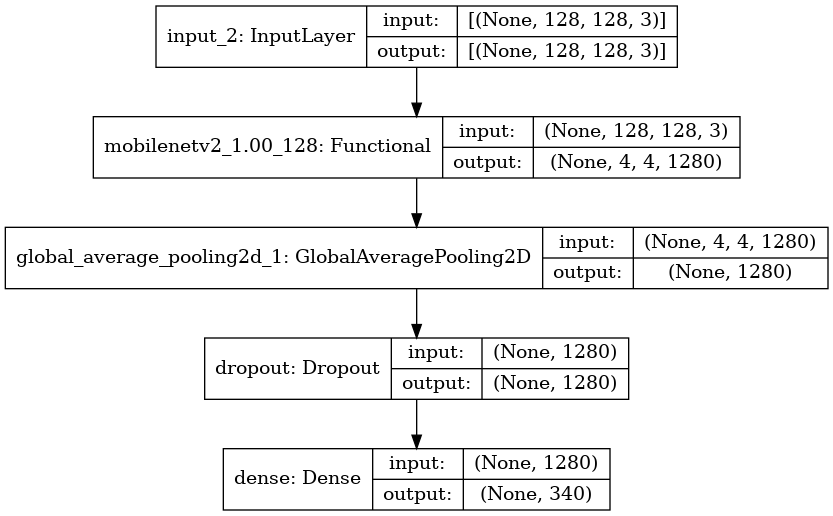

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile model
- tensorflow는 기본적으로 gpu를 사용할수 있으면 자동으로 사용한다고 했는데, 
- 터미널에서 gpu 메모리 실시간 사용량을 확인할때 내용이 잡히지 않아서 따로 gpu로 컴파일, 훈련을 진행해본다

In [37]:
# compile model
base_learning_rate = 0.0001

with tf.device('/GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

### Training

- 버전1 노트북에서는 steps_per_epoch를 generator만 사용했을때처럼 `len(train_generator)`로 사용하지 않고, batch_size로 한번더 나눈 값을 이용했는데, 이 부분은 다시 동일하게 맞춤

In [38]:
# calculate the total number of samples in your dataset
steps_per_epoch = len(train_generator)

# set checkpoint
checkpoint_filepath = './3.model_training/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(dataset,
                        epochs=20, steps_per_epoch=steps_per_epoch,
                       callbacks=[checkpoint_callback])

Epoch 1/20
15569/15569 [==============================] - 431s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0023
Epoch 2/20
15569/15569 [==============================] - 0s 0us/step - loss: 0.0000e+00 - accuracy: 0.0023


- 데이터가 없다는 경고문이 뜨면서 훈련이 종료됨
- generator를 사용하는데 데이터가 없을수 있나..?
- generator를 tf.data에 넣어서 사용하면서 배치사이즈가 다르게 설정되는걸까?

> **tf.data의 prefetch\(\)** <br>- 훈련 속도를 더 빠르게 <br>- prefetch(1)을 호출하면 다음 훈련에 사용할 배치 하나를 미리 준비


- tf.data는 사실 속도를 빠르게 하기 위해 prefetch 기능을 넣은것밖에 없는데 어떤 영향이 있는지 잘 모르겠다.


- 다시 len(train_generator)을 batch_size로 한번더 나눈 값으로 모델 훈련을 진행

In [39]:
# calculate the total number of samples in your dataset
total_samples = len(train_generator)

# calculate steps per epoch
steps_per_epoch = total_samples // batch_size

# compile model
with tf.device('/GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(dataset,
                        epochs=20, steps_per_epoch=steps_per_epoch,
                       callbacks=[checkpoint_callback])

Epoch 1/20
486/486 [==============================] - 17s 29ms/step - loss: 0.0000e+00 - accuracy: 0.0019
Epoch 2/20
486/486 [==============================] - 16s 32ms/step - loss: 0.0000e+00 - accuracy: 0.0024
Epoch 3/20
486/486 [==============================] - 15s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0021
Epoch 4/20
486/486 [==============================] - 15s 30ms/step - loss: 0.0000e+00 - accuracy: 0.0022
Epoch 5/20
486/486 [==============================] - 15s 30ms/step - loss: 0.0000e+00 - accuracy: 0.0026
Epoch 6/20
486/486 [==============================] - 15s 32ms/step - loss: 0.0000e+00 - accuracy: 0.0029
Epoch 7/20
486/486 [==============================] - 15s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0024
Epoch 8/20
486/486 [==============================] - 15s 31ms/step - loss: 0.0000e+00 - accuracy: 0.0026
Epoch 9/20
486/486 [==============================] - 15s 30ms/step - loss: 0.0000e+00 - accuracy: 0.0026
Epoch 10/20
486/486 [=========================

- 학습률을 조금 더 늘려서 학습을 진행해본다

In [41]:
base_learning_rate = 0.001

# compile model
with tf.device('/GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(dataset,
                        epochs=20, steps_per_epoch=steps_per_epoch,
                       callbacks=[checkpoint_callback])

Epoch 1/20
486/486 [==============================] - 16s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0032
Epoch 2/20
486/486 [==============================] - 14s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0028
Epoch 3/20
486/486 [==============================] - 14s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0026
Epoch 4/20
486/486 [==============================] - 14s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0026
Epoch 5/20
486/486 [==============================] - 14s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0026
Epoch 6/20
486/486 [==============================] - 14s 29ms/step - loss: 0.0000e+00 - accuracy: 0.0029
Epoch 7/20
486/486 [==============================] - 14s 29ms/step - loss: 0.0000e+00 - accuracy: 0.0024
Epoch 8/20
486/486 [==============================] - 14s 29ms/step - loss: 0.0000e+00 - accuracy: 0.0027
Epoch 9/20
486/486 [==============================] - 14s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0028
Epoch 10/20
486/486 [=========================

- 학습이 거의 이루어지지 않은걸 확인할수 있다. 
- 두번째 모델 vgg16 모델로 학습을 진행해본다

# 2. VGG16
- ImageNet 데이터셋으로 사전훈련됨
- 기본 input 사이즈 : 224x224
- [참고] ['Very Deep Convolutional Networks for Large-Scale Image Recognition' paper](https://arxiv.org/pdf/1409.1556.pdf)

### Base model - Feature extraction

In [42]:
# create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False, # only feature extraction
                                               weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [43]:
# check feature extractor
image_batch, label_batch = next(iter(dataset))
feature_batch = base_model(image_batch)

In [44]:
print(feature_batch.shape)

(32, 4, 4, 512)


In [45]:
# freeze the confolutional base
base_model.trainable = False

In [46]:
# check the base model architecture without classification layer
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

- 이 모델에는 BatchNormalization layer가 포함되어있지 않음
- 모델훈련에서는 training옵션을 True로 설정한다

### Classification layer

In [48]:
# add classification layer - make a single vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [49]:
# add classification layer - classify 340 labels
prediction_layer = tf.keras.layers.Dense(len(label_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

# check final shape
print(prediction_batch.shape)

(32, 340)


### Build model = base model + classification layer

In [50]:
# build model by chaining together
# use Functional API

inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=True)  # don't freeze layer - no batch normalization 
x = global_average_layer(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [51]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 340)               174420    
Total params: 14,889,108
Trainable params: 174,420
Non-trainable params: 14,714,688
_________________________________________________________________


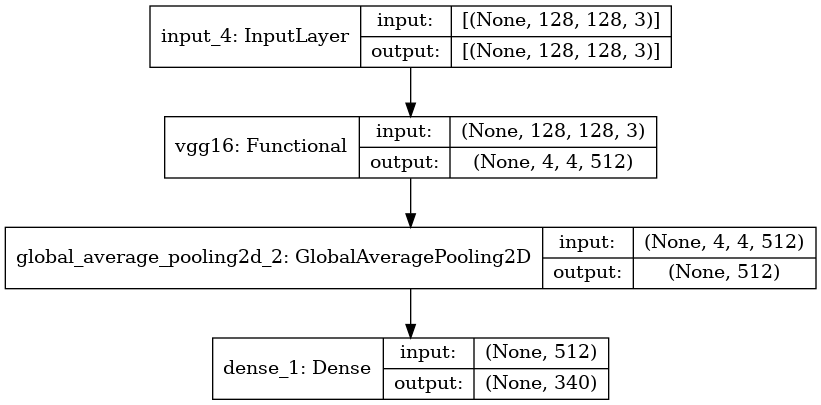

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Compile model
- tensorflow는 기본적으로 gpu를 사용할수 있으면 자동으로 사용한다고 했는데, 
- 터미널에서 gpu 메모리 실시간 사용량을 확인할때 내용이 잡히지 않아서 따로 gpu로 컴파일, 훈련을 진행해본다

In [56]:
# compile model
base_learning_rate = 0.01  # 학습속도가 크지않아서 이번 부터는 크게 설정

with tf.device('/GPU:0'):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

### Training

In [ ]:
# set checkpoint
checkpoint_filepath = './3.model_training/vgg_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

# calculate the total number of samples in your dataset
total_samples = len(train_generator)

# calculate steps per epoch
steps_per_epoch = total_samples // batch_size

# 모델 학습
with tf.device('/GPU:0'):
    history = model.fit(dataset,
                        epochs=20, steps_per_epoch=steps_per_epoch,
                       callbacks=[checkpoint_callback])

Epoch 1/20
486/486 [==============================] - 21s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0026
Epoch 2/20
486/486 [==============================] - 20s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 3/20
486/486 [==============================] - 20s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0028
Epoch 4/20
486/486 [==============================] - 20s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 5/20
486/486 [==============================] - 20s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0028
Epoch 6/20
486/486 [==============================] - 20s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0032
Epoch 7/20
486/486 [==============================] - 20s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0030
Epoch 8/20
486/486 [==============================] - 20s 41ms/step - loss: 0.0000e+00 - accuracy: 0.0031
Epoch 9/20
  4/486 [..............................] - ETA: 21s - loss: 0.0000e+00 - accuracy: 0.0000e+00